## Import Library

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflowjs
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.applications import mobilenet_v2, ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow import keras
import numpy as np
import uuid
import time
import pathlib
import warnings
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import imghdr

# Load The Datasets

In [2]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Setting Up Datasets
batch_size = 16
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/tmp/training_ind/food_datasets',
  seed = 123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/tmp/valid_ind/validation',
  seed = 123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 6899 files belonging to 4 classes.
Found 1721 files belonging to 4 classes.
['bakso', 'gado', 'rendang', 'sate']


# Visualize The Data

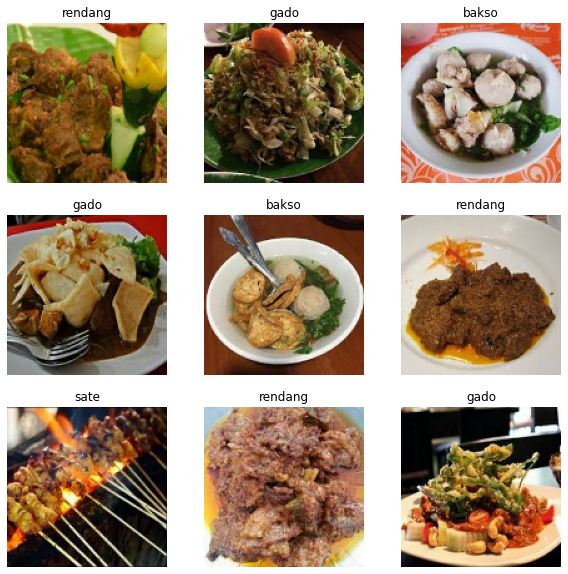

In [92]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Image Augmentation


In [93]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [94]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [95]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2,0.4)
  ]
)

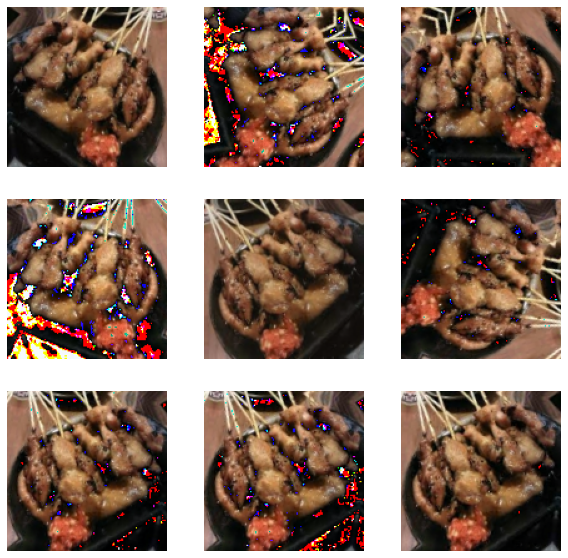

In [96]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Modelling

In [97]:
# Setting Up Checkpoint
# Keeping Highest Accuracy and Weight
checkpoint = ModelCheckpoint(filepath='./tmp/checkpoint', monitor="val_accuracy", mode="max",save_best_only=True, save_weights_only=True)

# Setting Up Callbacks
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.91: # @KEEP
                print("\nReached 91% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True


In [99]:
# Adding Layers
model = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  layers.DepthwiseConv2D(kernel_size=3,padding='valid'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(4)
])

In [100]:
# Setting Up Optimizer and Loss also adding the callback function into the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
callbacks = [myCallback(),checkpoint]

In [101]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_16 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
depthwise_conv2d_8 (Depthwis (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 31, 31, 64)      

In [102]:
history = model.fit(
              train_ds,
              validation_data=val_ds,
              epochs = 250,
              verbose = 1,
              callbacks=[callbacks]
            )

Epoch 1/250
432/432 [==============================] - 29s 62ms/step - loss: 1.5063 - accuracy: 0.5566 - val_loss: 1.7057 - val_accuracy: 0.4120
Epoch 2/250
432/432 [==============================] - 23s 54ms/step - loss: 0.7936 - accuracy: 0.6676 - val_loss: 1.3826 - val_accuracy: 0.5131
Epoch 3/250
432/432 [==============================] - 23s 54ms/step - loss: 0.6500 - accuracy: 0.7411 - val_loss: 0.7128 - val_accuracy: 0.7159
Epoch 4/250
432/432 [==============================] - 23s 53ms/step - loss: 0.5283 - accuracy: 0.7972 - val_loss: 0.6044 - val_accuracy: 0.7629
Epoch 5/250
432/432 [==============================] - 24s 56ms/step - loss: 0.4670 - accuracy: 0.8303 - val_loss: 0.9241 - val_accuracy: 0.6990
Epoch 6/250
432/432 [==============================] - 25s 57ms/step - loss: 0.4219 - accuracy: 0.8466 - val_loss: 0.9175 - val_accuracy: 0.6868
Epoch 7/250
432/432 [==============================] - 24s 56ms/step - loss: 0.3880 - accuracy: 0.8619 - val_loss: 0.7430 - val_ac

In [32]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Public\Documents\Wondershare\CreatorTemp\tmp8t6senl_\assets


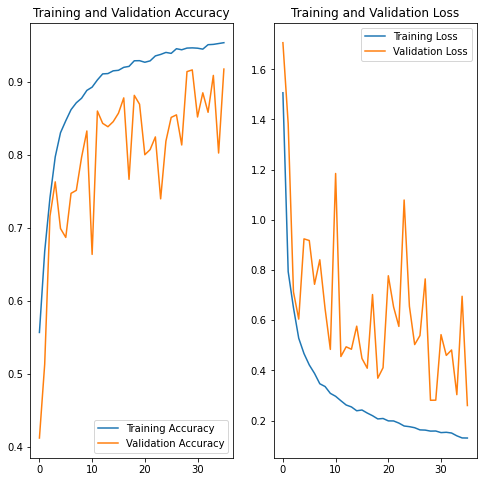

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(36)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [117]:
sunflower_path = '/tmp/test/1.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

[[-3.7532300e-03 -8.8143072e+00 -5.6382837e+00 -6.7595711e+00]]
tf.Tensor([9.9513823e-01 1.4842553e-04 3.5549859e-03 1.1584278e-03], shape=(4,), dtype=float32)
This image most likely belongs to bakso with a 99.51 percent confidence.


## Converting into Tensorflow.Js

In [111]:
saved_model_path = "./my_model.h5"
model.save(saved_model_path)
# !tensorflowjs_converter --input_format=keras {saved_model_path} './model'
!tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model {saved_model_path} './model'

Writing weight file './model'\model.json...


2022-06-07 17:58:03.732635: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 17:58:05.050888: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2707 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1
2022-06-07 17:58:11.253420: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-06-07 17:58:26.004595: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-06-07 17:58:26.005264: I tensorflow/core/grappler/clusters/single_mach